In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
from pathlib import Path
import subprocess
from platformdirs import user_cache_dir
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import ms_pred.common as common
from ms_pred.dag_pred.iceberg_elucidation import candidates_from_pubchem, iceberg_prediction, load_real_spec, load_pred_spec, elucidation_over_candidates, plot_top_mols, explain_peaks, modi_finder, generate_buyable_report

/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /home/roger/ms-pred

/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred


# Global configs
Please modify the following paths/configs accordingly; for `pythonpath` on molgpu, you can either
1) set up your own ms-gen environment from source
2) use Mrunali's pre-built environment, after telling conda to look in my folder with `conda config --add envs_dirs /home/mrunali/miniconda3/envs`
3) Clone Mrunali's pre-built environment into your own environment with `conda --clone` and then source that instead.

In [3]:
config = dict(
    python_path='/home/roger/miniforge3/envs/ms-main/bin/python',
    gen_ckpt='/home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt',
    inten_ckpt='/home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt',
    cuda_devices=0,
    batch_size=8,
    num_workers=6,
    sparse_k=100,
    max_nodes=100,
    threshold=0.0,
    binned_out=False,
    ppm=20,
    num_bins=15000,
    dist_func='entropy'
)

The following cell enables SA score. See instructions in [the rdkik blog](https://greglandrum.github.io/rdkit-blog/posts/2023-12-01-using_sascore_and_npscore.html)
You can safely skip it if you are not setting ``sa_score=True`` in function ``plot_top_mols``

In [4]:
# sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
sys.path.append(os.path.join('/home/roger/miniforge3/envs/ms-main','share','RDKit','Contrib'))
from SA_Score import sascorer

## Round 1

In [27]:
def elucidation(spec_file, formula, adduct, energy, real_smi=None, name="", vis_peaks=False, buyable_report=False, **kwargs):
    _config = copy.deepcopy(config)
    _config['nce'] = False # use nce for collision energy
    _config['merge_spec'] = True # merge spec fro visualization
    _config['adduct'] = adduct
    for k, v in kwargs.items():
        _config[k] = v
    exp_spec_path = f'/home/roger/ms_collaborators/David/{spec_file}.ms'

    # Get candidates
    smiles = candidates_from_pubchem(formula)

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(smiles, energy, **_config)

    # Compare spectrum similarity for elucidation
    topk_results = elucidation_over_candidates(result_path, exp_spec_path, precursor_mass=pmz, mol_name=name, real_smiles=real_smi, topk=10, **_config)

    # Plot top results
    img = plot_top_mols(topk_results)

    # Visualize and explain peaks
    if vis_peaks:
        explain_peaks(result_path, exp_spec_path, pmz, real_smi, num_peaks=10, save_path='gaba_arg.pdf', **_config)

    # Buyable report
    if buyable_report:
        generate_buyable_report(
            [spec_file], # names
            [exp_spec_path], #exp_specs
            [{adduct: smiles}], # adduct_to_smiles
            _config,
            energy, topk_per_row=10, output_name=f'david_{spec_file}_buyable_report')

    return img

CUDA_VISIBLE_DEVICES=0 /home/roger/miniforge3/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
               --batch-size 8 \
               --num-workers 6 \
               --dataset-labels /home/roger/.cache/ms-pred/iceberg-elucidation/3b3c74085663a49269136999273ab052/cands_df_iceberg_elucidation.tsv \
               --sparse-out \
               --sparse-k 100 \
               --max-nodes 100 \
               --threshold 0.0 \
               --gen-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt \
               --inten-checkpoint /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
               --save-dir /home/roger/.cache/ms-pred/iceberg-elucidation/3b3c74085663a49269136999273ab052 \
               --gpu \
               --adduct-shift


Global seed set to 42


2024-10-18 16:16:08,208 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/roger/.cache/ms-pred/iceberg-elucidation/3b3c74085663a49269136999273ab052/cands_df_iceberg_elucidation.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 100
num_bins: 15000
num_workers: 6
save_dir: /home/roger/.cache/ms-pred/iceberg-elucidation/3b3c74085663a49269136999273ab052
seed: 42
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-10-18 16:16:08,560 INFO: Loaded gen / inten models from /home/roger/ms-models/iceberg_results_20240630/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/roger/ms-models/iceberg_results_20240630/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-10-18 16:16:

  0%|          | 0/258 [00:00<?, ?it/s]

2024-10-18 16:16:15,656 INFO: There are 2060 entries to process


100%|██████████| 258/258 [01:11<00:00,  3.63it/s]


2024-10-18 16:17:26,723 INFO: Program finished in: 78.52232432365417 seconds


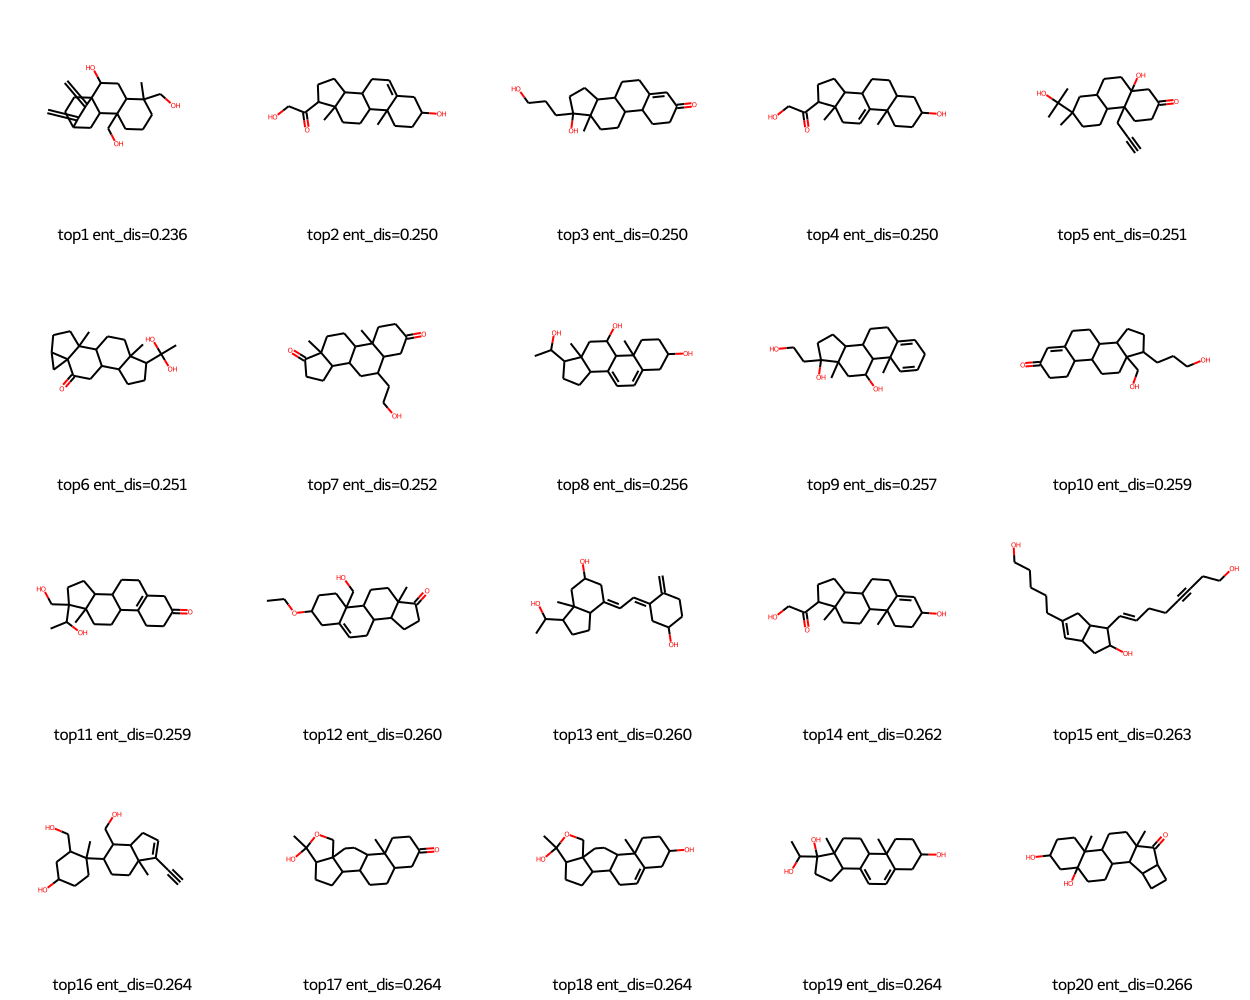

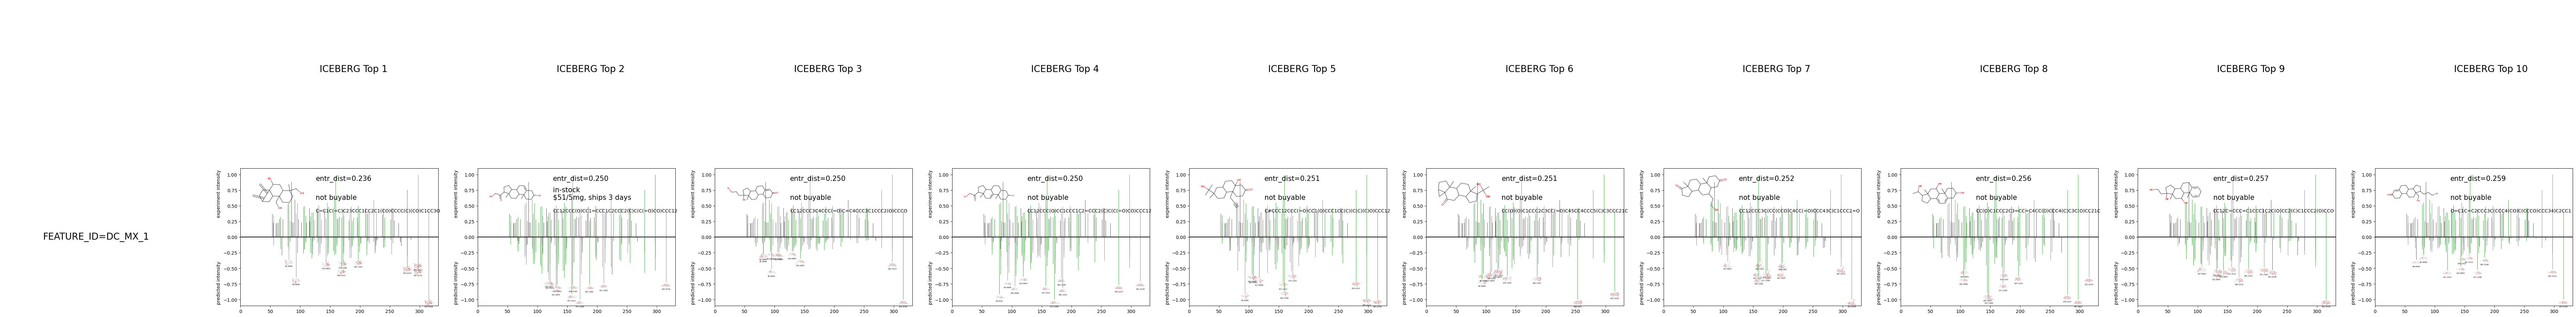

In [26]:
elucidation('DC_MX_1', 'C21H32O3', '[M-H2O+H]+', [30], buyable_report=True)

In [24]:
elucidation('DC_1', 'C38H47N2O14', '[M+H]+', [15, 30, 45])

ValueError: Empty candidate list!